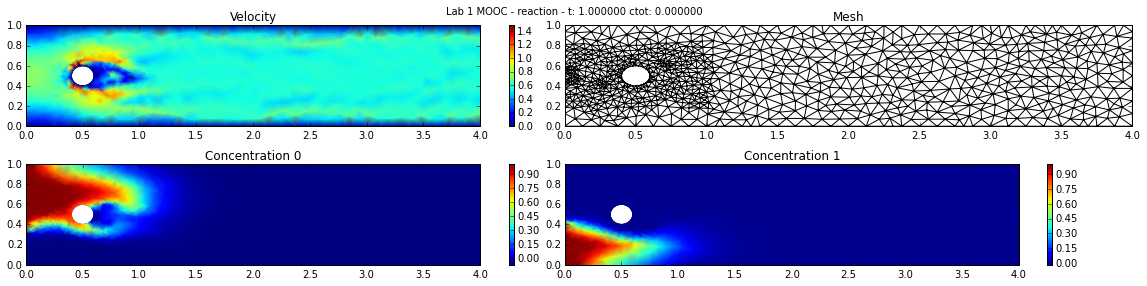

In [ ]:
%matplotlib inline
%run /home/fenics/fenics-matplotlib.py
from dolfin import *
from mshr import *
from IPython.display import display, clear_output
import logging; logging.getLogger('FFC').setLevel(logging.WARNING)
import time

# Geometry and mesh
XMIN, XMAX, YMIN, YMAX = 0., 4., 0, 1.
G = [XMIN, XMAX, YMIN, YMAX]
eps = 1e-5
mresolution = 30
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(.5, .5), .1), mresolution)
NC = 2 # Number of chemical species

nrefinement=2
for i in range(0, nrefinement): # Refine mesh
    cell_markers = MeshFunction("bool", mesh, mesh.topology().dim());
    for c in cells(mesh):
        p = c.midpoint()
        cell_markers[c] = (abs(p[0] - .5) < .5 and abs(p[1] - .5) < .3 and c.diameter() > .1) or c.diameter() > .2
    mesh = refine(mesh, cell_markers)

# FEM functions
V = VectorFunctionSpace(mesh, "CG", 1);
Q = FunctionSpace(mesh, "CG", 1);
W = V * Q;
h = CellSize(mesh);
(v, q) = TestFunctions(W);
w = Function(W);
(u, p) = (as_vector((w[0], w[1])), w[2]);
u0 = Function(V)
Z = VectorFunctionSpace(mesh, "CG", 1, NC);
c = Function(Z);
c0 = Function(Z);
z = TestFunction(Z)

def plot(u, c, t, ctot, stepcounter):
    if stepcounter % 5 == 0:
        uEuclidnorm = project(sqrt(inner(u, u)), Q);
        c1_0 = project(c[0], Q);
        c1_1 = project(c[1], Q)
        ax.cla();
        fig = plt.gcf();
        fig.set_size_inches(16, 4)
        plt.subplot(2, 2, 1);
        mplot_function(uEuclidnorm);
        plt.title("Velocity") # Plot norm of the velocity
        if t == 0.:
            plt.colorbar();
            plt.axis(G)
        plt.subplot(2, 2, 2);
        if t == 0.:
            plt.triplot(mesh2triang(mesh), color='#000000');
            plt.title("Mesh") # Plot mesh
        plt.subplot(2, 2, 3);
        mplot_function(c1_0); # Plot concentration 0
        plt.title("Concentration 0");
        plt.axis(G); 
        if t == 0.:
            plt.colorbar()
        plt.subplot(2, 2, 4);
        mplot_function(c1_1); # Plot concentration 1
        plt.title("Concentration 1");
        plt.axis(G);
        if t == 0.:
            plt.colorbar()
        plt.suptitle("Lab 1 MOOC - reaction - t: %f ctot: %f" % (t, ctot))
        plt.tight_layout();
        clear_output(wait=True);
        display(pl)    

uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX) # Inflow velocity
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps)
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps)
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps)
cm = Expression("x[1] > 0.4 ? 1. : 0.")

k = 0.1; # timestep
nu = 1e-6; # diffusion
delta = .2*h**(3./2.) # stabilization coefficient
t, T = 0., 10.; # time interval
kappa = 10.; # reaction coefficient
gamma = 10*1./h # penalty parameter

pl, ax = plt.subplots();
stepcounter = 0;
ctot = 0.; # Total concentration
timer0 = time.clock()
while t < T: # Time-stepping loop
    # Weak residual of stabilized FEM for Navier-Stokes eq.
    um = .5*(u + u0) # velocity u at midpoint of time interval
    r = ((inner(u - u0, v)/k + nu*inner(grad(um), grad(v)) + inner(grad(p) + grad(um)*um, v) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary cond.
        delta*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    solve(r==0, w)  # Solve the Navier-Stokes PDE (one timestep)

    # Weak residual of stabilized FEM for Reaction-Diffusion eq.
    r_C = ((inner(c - c0, z)/k + inner(dot(grad(c), u), z))*dx + kappa*(c[0]*c[1]*z[0] + c[0]*c[1]*z[1])*dx +
        gamma*(im*cm*inner(c[0] - 1., z[0]) + im*(1. - cm)*inner(c[1] - 1., z[1]))*ds + # Weak boundary cond.
        delta*inner(grad(c)*u, grad(z)*u)*dx + delta*inner(grad(c), grad(z))*dx) # Stabilization
    solve(r_C==0, c) # Solve the convection-reaction-diffusion PDE (one timestep)
    
    Mc = k*om*(c[0] + c[1])*ds; ctot += assemble(Mc) # Compute total concentration flowing out
    plot(u, c, t, ctot, stepcounter) # Plot all quantities (see implementation above)

    t += k; # Shift to next timestep
    stepcounter += 1;
    u0 = project(u, V);
    c0 = project(c, Z) 
plt.close();
print "elapsed CPU time: ", (time.clock() - timer0)
print "Total concentration: ", ctot 